In [1]:
import numpy as np
from QAM_EncoderDecoder import * 
import commpy
from scipy.io.wavfile import write, read
import matplotlib.pyplot as plt
import sounddevice as sd
import soundfile as sf
from scipy.signal import csd, chirp
import binascii
from scipy.signal import correlate
from IPython.display import Audio
%matplotlib inline

1. Create a block of pseudo-random constellation values
2. Add chirp at beginning and transmit OFDM block repeatedly
3. Convolve with inverse chirp to synchronise
4. Trim to just OFDM blocks
5. Average to block length n, take DFT, divide by tx constellation values to recover channel tf
6. Take iDFT to get impulse response of channel

In [2]:
N = 1024 # for dft length, no symbols
prefix_no = 400
fs = 44100

#random_symbol = np.random.randint(0,100, int(N/4)) # easier to test if same every time
# NEED TO CHANGE TO PSEUDO RANDOM SIGNALS
random_symbol = np.array([81, 41, 51, 46, 19, 27, 84, 53,  0, 86, 54, 17, 33, 32,  8, 24, 19,
       38, 58, 28, 74, 10, 39, 24, 39, 22, 59, 58, 70, 74, 82, 64,  4, 77,
       98, 50, 26, 36, 21, 32, 56, 27, 92, 42, 63, 91, 67, 76, 65, 40, 17,
       49, 66, 42, 87, 20, 50, 89, 48, 47, 40, 29, 57, 40, 92, 73,  8, 26,
       12, 76, 24, 82, 43, 14, 40, 19, 56, 97, 78, 43, 96, 43, 89,  6, 11,
       98, 58, 25, 91, 16, 40, 77, 52,  9, 34, 45, 36, 69, 12, 29, 38, 45,
       88, 14, 20, 49,  1, 61, 48, 36, 10, 44, 44,  5,  7, 34, 26, 72,  7,
       63, 68, 27, 12, 71, 39, 54, 96,  1, 70, 67, 76, 30, 77, 73, 28, 88,
       31, 17, 86, 62,  1, 12, 35, 74,  3, 87, 73, 26, 83, 73,  6,  3, 32,
       37, 39, 53, 90, 88, 60, 89, 93, 91,  4, 53,  5,  4,  4, 58, 35, 63,
       27, 77, 51, 87, 24, 31, 16,  4, 87, 98, 52, 90, 68, 37, 75, 56, 34,
       30, 50, 26, 20, 96, 51, 94, 60, 55, 14, 74,  4, 73, 13, 45, 67,  8,
       61, 12, 93,  6, 87, 14, 90, 64, 33, 29, 68, 13, 60, 18,  9, 60,  3,
       15,  6, 48, 34, 44, 63, 25, 39, 18,  5, 56, 38, 46,  6, 64, 36, 29,
       90, 47, 23, 29, 97, 19,  5, 47, 30, 63, 98, 99, 20, 91, 69, 24, 35,
       59])

about to do encode_bitstr2symbols encoding
encode_bitstr2symbols encoding finished
257
513
1024
[-0.00432051+0.j -0.01096393+0.j -0.00750128+0.j ...  0.00976539+0.j
  0.09362931+0.j  0.15461746+0.j]
(1, 1064)


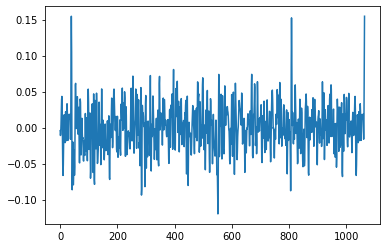

In [3]:
bin_strings=''
for byte in random_symbol:
    binary_string = '{0:08b}'.format(byte)
    bin_strings+=binary_string

symbols = encode_bitstr2symbols(bin_strings)
symbols = symbols[:N//4] # reduced num info bins to 256 so need fewer symbols for a single OFDM symbol

# change info bins to just 256 corresponding to ~ 11kHz
info_bins=int(N//4) # so here now 256 info bins - same as num symbols -> so one OFDM symbol
OFDM_frames=[]

# start from 3rd bin (~82 Hz onward) too??

OFDM_frames = []
# for each OFDM block

for i in range (0,len(symbols),info_bins):
    OFDM_block=[0] #frequency bins 0 and 512(int(N/2)) contains value 0
    # start from 3rd bin? depends on bandwidth, N etc.
    OFDM_block[1:]=symbols[i:i+info_bins]
    print(len(OFDM_block))
    #add 0s to the end when data is not an integer factor of 512
    while len(OFDM_block)<=((N/2)): # change from info_bins as thats now reduced - crucial for conjugate symmetry
        OFDM_block.append(0)
    # merge lines above/below?
    #OFDM_block.append(0)#frequency bins 0 and 512(int(N/2)) contains value 0
    print(len(OFDM_block))
    # reverse conjugate
    for j in range(len(OFDM_block)-2,0,-1): # count up or down
        OFDM_block.append(np.conj(OFDM_block[j]))
    print(len(OFDM_block))    
    #----iDFT----
    OFDM_frame=np.fft.ifft(OFDM_block, n=N)

    # ----add cyclic prefix----
    cyclic_prefix = OFDM_frame[N-prefix_no:N]

    OFDM_frame = np.append(cyclic_prefix, OFDM_frame, axis=0)        
    OFDM_frames.append(OFDM_frame)

print(OFDM_frames[0])
OFDM_frames = np.real(OFDM_frames) # only to get rid of +0j parts after iFFT
print(np.shape(OFDM_frames))
plt.plot(OFDM_frames[0])

frame = OFDM_frames[0]

In [4]:
pass
"""frame = symbol_to_OFDMframes(symbols, N, prefix_no)[0] # original shape is (1, 1056)

#frame = np.fft.ifft(symbols)

#cyclic_prefix = frame[len(symbols)-prefix_no:len(symbols)]        
#frame = np.append(cyclic_prefix, frame, axis=0) * 2
print(frame)
frame = np.real(frame) # valid???

print(frame)

plt.plot(frame)"""


'frame = symbol_to_OFDMframes(symbols, N, prefix_no)[0] # original shape is (1, 1056)\n\n#frame = np.fft.ifft(symbols)\n\n#cyclic_prefix = frame[len(symbols)-prefix_no:len(symbols)]        \n#frame = np.append(cyclic_prefix, frame, axis=0) * 2\nprint(frame)\nframe = np.real(frame) # valid???\n\nprint(frame)\n\nplt.plot(frame)'

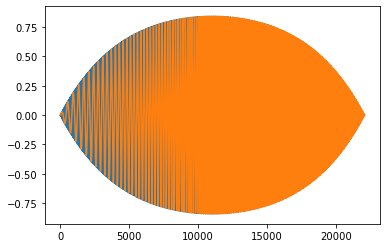

In [5]:
# linear or log chirp

sec = 0.5
k = 10 # around 10?
fl = 100
fu = 1000

t = np.linspace(0, sec, int(fs*sec))

ch_lin = chirp(t, f0=fl, f1=fu, t1=sec, method='linear') # can be linear, quadratic or logarithmic
ch_lin *= (1-np.exp(-k*t))*(1-np.exp(-k*(sec-t))) /5 # /5 scale to match size of ofdm?
inv_ch_lin = np.flip(ch_lin)

# form of log chirp

ch_log = np.sin(2 * np.pi * fl * sec * (np.exp( t * (np.log(fu / fl) / sec)) -1) /np.log(fu / fl) )
ch_log *= (1-np.exp(-k*t))*(1-np.exp(-k*(sec-t)))
mod = np.exp(-t * np.log(fu / fl) / sec)
inv_ch_log = np.flip(ch_log)

ch = ch_log
ch = np.tile(ch, 1) # repeat num chirps

T = 0.0
inv_ch = inv_ch_log
inv_ch = np.concatenate((np.zeros(int(T*fs)), inv_ch), axis=None) # time reverse and delay the chirp
plt.plot(inv_ch)
plt.plot(ch)

In [6]:
repeats = 100
repeat = np.tile(frame, repeats) # transmit repeated frames

# multiply by root raised cosine before transmission?
"""
alpha = 0.5
Ts = (N/4) / fs
pulse = np.array(commpy.filters.rrcosfilter(int(N/4), alpha, Ts, fs)[1]) / 5
print(pulse.shape)
baseband = np.convolve(repeat, pulse)
plt.plot(repeat)
repeat = baseband
plt.plot(repeat)
"""

'\nalpha = 0.5\nTs = (N/4) / fs\npulse = np.array(commpy.filters.rrcosfilter(int(N/4), alpha, Ts, fs)[1]) / 5\nprint(pulse.shape)\nbaseband = np.convolve(repeat, pulse)\nplt.plot(repeat)\nrepeat = baseband\nplt.plot(repeat)\n'

Chirp 1 starts at: 4410   OFDM starts at:  30870 Chirp 2 starts at:  141680 Dist between chirps:  137270


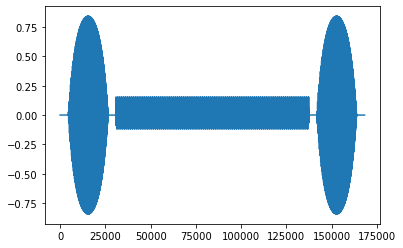

In [7]:
gap = int(0.1*fs)
combined = np.concatenate((np.zeros(gap), ch, np.zeros(gap), repeat, np.zeros(gap), ch, np.zeros(gap)), axis=None)
print("Chirp 1 starts at:", gap, "  OFDM starts at: ", (2*gap)+len(ch), "Chirp 2 starts at: ", (3*gap)+len(ch)+len(repeat), "Dist between chirps: ", (2*gap)+len(ch)+len(repeat))
tx_diff = 2*gap + len(ch)
#print("Transmitted diff: ", tx_diff)
plt.plot(combined)

3.812766439909297


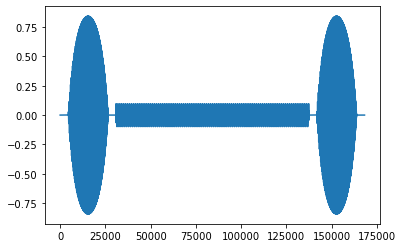

In [8]:
channel = [0.5, 0.25, 0, 0.25]
chan_fft = np.fft.fft(channel,N)
channel_op = np.convolve(channel, combined)
plt.plot(channel_op)
print(len(channel_op)/fs)

In [9]:
####### OR
testing_real = True # check with ideal channel

if testing_real:
    sd.play(combined, fs)
    sf.write('sync_log.wav', combined, fs)

Done


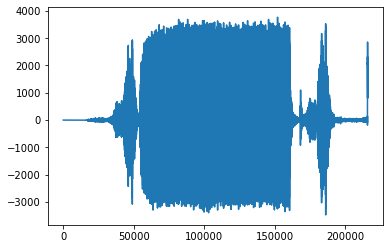

In [111]:
if testing_real:
    from pydub import AudioSegment
    recording = AudioSegment.from_file('sync2.m4a')
    recording = recording.get_array_of_samples()
    plt.plot(recording)

    sf.write('sync_long_rec.wav', recording, fs)
    #plt.plot(recording)
    print("Done")
    channel_op = np.array(recording)


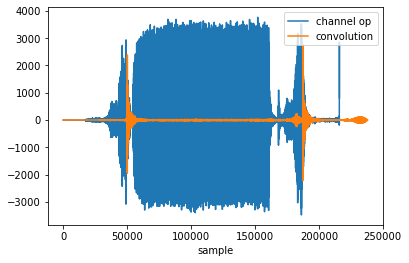

In [112]:
conv = np.convolve(channel_op, inv_ch)
plt.plot(channel_op, label='channel op')
plt.plot(conv/1000, label='convolution')
plt.xlabel('sample')
plt.legend(loc='upper right')

Convolution peak 1: 50122
Convolution peak 2: 187392
Dist:  137270


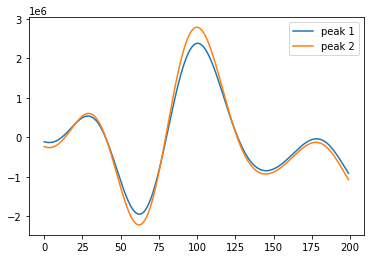

In [113]:
peak1 = np.argmax(conv[0:int(len(conv)/2)]) # checks first half of convoluted signal for peak
peak2 = np.argmax(conv[int(len(conv)/2):]) + int(len(conv)/2) + 0
print("Convolution peak 1:", peak1)
print("Convolution peak 2:", peak2)
plt.plot(conv[peak1-100:peak1+100], label='peak 1')
plt.plot(conv[peak2-100:peak2+100], label='peak 2')
plt.legend()
print("Dist: ", peak2 - peak1)

1064
Start:  54532 End:  160932 Length:  106400
106400
106400


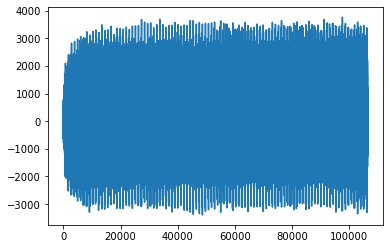

In [128]:
# EXPERIMENT WITH CHANGING OFFSET TO SEE PHASE DIFFERENCE ON RECEIVED SYMBOLS

offset = 0 # current rough synchronisation error
print(len(frame))

rx_begin = peak1 + gap - int(T*fs) + offset # channel IR adjusts this value
rx_end = peak2 - gap - len(ch) - int(T*fs) + offset
print("Start: ", rx_begin, "End: ", rx_end, "Length: ", rx_end - rx_begin)

rx_OFDM = channel_op[rx_begin:rx_end] # mismatch between length of frames expected & received
print(len(rx_OFDM))
#rev_pulse = np.flip(pulse)
#rx_OFDM = np.convolve(rx_signal, rev_pulse)
single_frame = rx_OFDM[0:len(frame)]
print(len(rx_OFDM))
plt.plot(rx_OFDM)

Diff:  23662


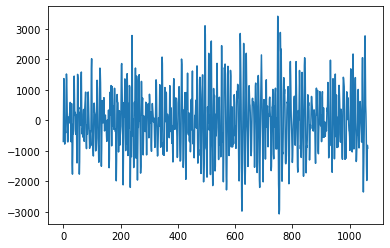

In [129]:
frames = np.split(rx_OFDM, repeats)
avg_frame = np.zeros(len(frame))
for frame in frames:
    avg_frame = np.add(avg_frame, frame)
avg_frame /= repeats
#print(avg_frame)
plt.plot(avg_frame)
print("Diff: ", rx_begin - ((2*gap)+len(ch))) 

[(-1+1j), (-1+1j), (1+1j), (-1+1j), (1+1j), (1-1j), (1-1j), (-1+1j), (1+1j), (-1-1j)]
[-2451.14137688 -402.69710553j -2290.03727817 +307.63120302j
 -1543.19177715  +74.0770095j  -2367.49094728 +323.01256984j
 -1903.81389979 +460.88718939j -1908.00691494 -131.21969009j
 -2278.60199536 -521.98817754j -1093.00454543+1703.65022208j
  -894.73338023 +604.88242523j -1922.11503351 +986.99232061j]
[ 0.5       +0.j          0.06359941+0.23395187j -0.10757746-0.14278067j
  0.28680034-0.2504954j ]
C:\Users\H1937\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


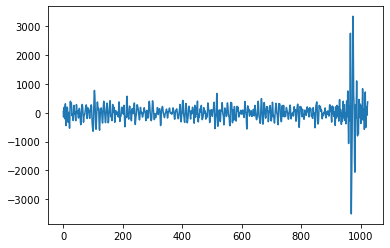

In [130]:
# remove cp, reduce to info symbols only
trim_frame = avg_frame[prefix_no: prefix_no+N]

rx_dft = np.fft.fft(trim_frame, N)[1:(N//4)+1] # get info symbols stored

print(symbols[:10])
print(rx_dft[:10])

norm_rx_dft = rx_dft / np.array(symbols)

imp_response = np.fft.ifft(norm_rx_dft,N)

#print((channel[0]/imp_response[0])*imp_response[0:4])

plt.plot((imp_response)[:])

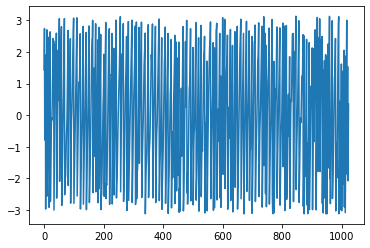

In [131]:
phase = np.angle(imp_response)
plt.plot(phase[:])
# will change for sampling freq offset?

In [132]:
norm_rx_dft.shape

(256,)